# Fuzzy Suitability Analysis
This notebook 
* calculate Euclidean distances based on criteria
* assign fuzzy membership 
* conduct fuzzy overlay (AND operator)
* filter suitable areas of interest based on 1. defined memebership degree cut-off value, 2. size of areas
* save the GeoDataFrame of polygons of suitable areas and labels of polygons as list (set P)

Note: There are still two parts that need to be figured out:
1. Select land use by categories - only land use types that are acceptable for building digesters should be in the fuzzy analysis. 
2. Including digester scale in the filter of suitable areas by size and how to represent that.

In [14]:
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio
import matplotlib.pyplot as plt

from scipy import ndimage
from scipy.ndimage import distance_transform_edt
from cflp_function import store_data_to_pickle
from rasterio.plot import show
from rasterio.features import shapes, geometry_mask
from rtree import index
from shapely.geometry import Point, Polygon, MultiPolygon, LineString, mapping
from scipy.spatial import cKDTree

In [2]:
%matplotlib inline

## 1. Load data

Small digester criteria:
* Proximity to farm 
* Proximity to road network

In [3]:
farm = gpd.read_file(r"./farm/farm_new.shp")
farm.head()

,IND_OBJ_KE,IND_WAARDE,IND_WAARD0,IND_OBJ_AA,IND_OBJ_NA,IND_OBJ_BE,IND_OBJ_GR,IND_PERIOD,IND_THEMA,IND_CULT_D,OBJECTID,geometry
0,"driebeukig gebouw, ankerbalkgebint, stallen aa...",Rijksbeschermd,NaN,Ja,507920,hallehuisgroep (hallehuis - dwarshuistype),boerderijtypen,moderne tijd,landbouw,Gebouwd erfgoed,557.0,POINT (6.76584 52.31414)
1,"driebeukig gebouw, ankerbalkgebint, stallen aa...",Rijksbeschermd,NaN,Ja,507950,hallehuisgroep (hallehuis - dwarshuistype),boerderijtypen,moderne tijd,landbouw,Gebouwd erfgoed,558.0,POINT (6.83725 52.42508)
2,"driebeukig gebouw, ankerbalkgebint, stallen aa...",Rijksbeschermd,NaN,Ja,507953,hallehuisgroep (hallehuis - dwarshuistype),boerderijtypen,moderne tijd,landbouw,Gebouwd erfgoed,559.0,POINT (6.85936 52.38622)
3,"driebeukig gebouw, ankerbalkgebint, stallen aa...",Rijksbeschermd,NaN,Ja,507962,hallehuisgroep (hallehuisboerderij),boerderijtypen,moderne tijd,landbouw,Gebouwd erfgoed,560.0,POINT (6.75348 52.43438)
4,"driebeukig gebouw, ankerbalkgebint, stallen aa...",Rijksbeschermd,NaN,Ja,507964,hallehuisgroep (t-huisboerderij),boerderijtypen,moderne tijd,landbouw,Gebouwd erfgoed,561.0,POINT (6.48408 52.24362)


In [4]:
road = gpd.read_file(r"./osm_network/G_e.shp")
road.head()

,u,v,key,highway,geometry
0,0,1,0,primary,"LINESTRING (732329.118 6863326.894, 732282.965..."
1,0,2,0,primary,"LINESTRING (732329.118 6863326.894, 732424.976..."
2,1,0,0,primary,"LINESTRING (732029.302 6862992.539, 732169.520..."
3,1,491,0,primary,"LINESTRING (732029.302 6862992.539, 731998.678..."
4,2,3,0,motorway_link,"LINESTRING (732826.405 6863768.536, 732776.088..."


In [5]:
road = road.to_crs('EPSG:4326')

In [8]:
# Load raster data
raster_path = './raster/lu_50_3857.tif'
# raster_path = './raster/agri_50.tif'
# raster_path = './raster/agri_clip.tif'
with rasterio.open(raster_path) as src:
    print(src.meta)
    print(src.transform)
    LU = src.read(1)  # Assuming it is a single band raster

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 1681, 'height': 1400, 'count': 1, 'crs': CRS.from_epsg(3857), 'transform': Affine(50.0, 0.0, 703909.1518017336,
       0.0, -50.0, 6890914.957877071)}
| 50.00, 0.00, 703909.15|
| 0.00,-50.00, 6890914.96|
| 0.00, 0.00, 1.00|


In [12]:
with rasterio.open('/Users/wenyuc/Desktop/lu_4326/ind_50_3857.tif') as src_industry:
    print(src_industry.meta)
    print(src_industry.transform)
    industry = src_industry.read(1)  # Assuming it is a single band raster

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 1681, 'height': 1400, 'count': 1, 'crs': CRS.from_epsg(3857), 'transform': Affine(50.0, 0.0, 703909.1518017336,
       0.0, -50.0, 6890914.940829566)}
| 50.00, 0.00, 703909.15|
| 0.00,-50.00, 6890914.94|
| 0.00, 0.00, 1.00|


In [ ]:
with rasterio.open('/Users/wenyuc/Desktop/lu_4326/nat_50_3857.tif') as src:
    print(src.meta)
    print(src.transform)
    nature = src.read(1)  # Assuming it is a single band raster

## 2. Calculate Euclidean Distances


In [57]:
def save_raster(raster_path, new_raster_path, new_raster):
    # Open the original raster file
    with rasterio.open(raster_path) as src:
        # Retrieve the metadata from the original raster file
        profile = src.profile
        # Update the metadata for the new raster file with the data from distances_farm
        profile.update(
            dtype=rasterio.float32,
            count=1
        )
        # Save the distances_farm array as a new raster file
        with rasterio.open(new_raster_path, 'w', **profile) as dst:
            dst.write(new_raster, 1)

In [14]:
# Create a mask to identify non-zero values, the cells with zero are background cells
background_value = 0  # Adjust this if the background value is different
mask = LU != background_value

### Euclidean Distance - Raster to Point (farm points)

In [ ]:
def ckdtree_point(poi_df, original_raster, mask, src):
    # Convert farm geometries to NumPy array
    point_geometries = np.array([(geom.x, geom.y) for geom in poi_df.geometry])

    # Create a KDTree for fast nearest-neighbor search
    tree = cKDTree(point_geometries)

    # Create new array in the shape of LU and fill with inf values 
    D = np.full_like(original_raster, np.inf, dtype=np.float64)

    # Iterate through each cell
    for row in range(original_raster.shape[0]):
        for col in range(original_raster.shape[1]):
            if mask[row, col]:  # Check the mask to exclude background values
                cell_center = src.xy(row, col)
                point = Point(cell_center)

                # Use the KDTree to find the index of the nearest farm
                j = tree.query([cell_center], k=1)[1][0]

                f = poi_df.geometry.iloc[j]
                d = point.distance(f)

                if d < D[row, col]:
                    D[row, col] = d
    return D


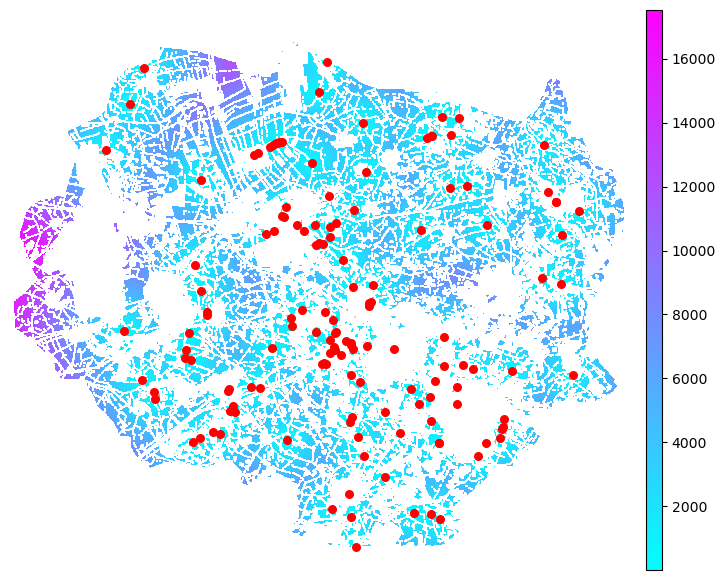

In [18]:
with rasterio.open(r'./raster/d_to_farm_complete_ckdtree_50.tif') as src_farm:

    d_to_farm_raster = src_farm.read(1)
    
    # Plot the raster
    fig, ax = plt.subplots(figsize=(8, 8))
    show(src_farm, ax=ax, cmap= 'cool')

    # Plot the farms
    farm.plot(ax=ax, marker='o', color='red', markersize=30)
    # road.plot(ax=ax)

    # # Add colorbar
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = plt.colorbar(ax.get_images()[0], cax=cax)

    ax.axis('off')

    # Show the plot 
    plt.savefig('/Users/wenyuc/Desktop/UT/outputs/d_to_farm_complete_ckdtree_50.png', dpi=1000)
    plt.show()

In [30]:
# # Check if the arrays are equal
# are_equal = np.array_equal(distance_to_farm, d_to_farm)

# if are_equal:
#     print("The arrays are equal.")
# else:
#     print("The arrays are not equal.")

The arrays are equal.


### Euclidean Distance - Raster to LineStrings (road network)

In [ ]:
def ckdtree_line(line_df, original_raster, mask, src):
    # Convert road geometries to NumPy array
    line_data = np.concatenate([np.array(line.coords) for line in line_df.geometry])

    # Create a KDTree for fast nearest-neighbor search
    tree = cKDTree(line_data)    
    
    # Create a new array in the shape of LU and fill with inf values
    D = np.full_like(original_raster, np.inf, dtype=np.float64)

    # Iterate through each cell
    for row in range(original_raster.shape[0]):
        for col in range(original_raster.shape[1]):
            if mask[row, col]:  # Check the mask to exclude background values
                cell_center = src.xy(row, col)
                point = Point(cell_center)

                # Use the KDTree to find the index of the nearest road point
                j = tree.query([cell_center], k=1)[1][0]

                # Extract the coordinates of the nearest road point
                nearest_point_coords = line_data[j]

                # Convert the road point coordinates to a Shapely Point
                nearest_point_coords_shapely = Point(nearest_point_coords)

                # Calculate the distance from the raster cell to the nearest road point
                d = point.distance(nearest_point_coords_shapely)

                # Update the distance array if the calculated distance is smaller
                if d < D[row, col]:
                    D[row, col] = d
    return D

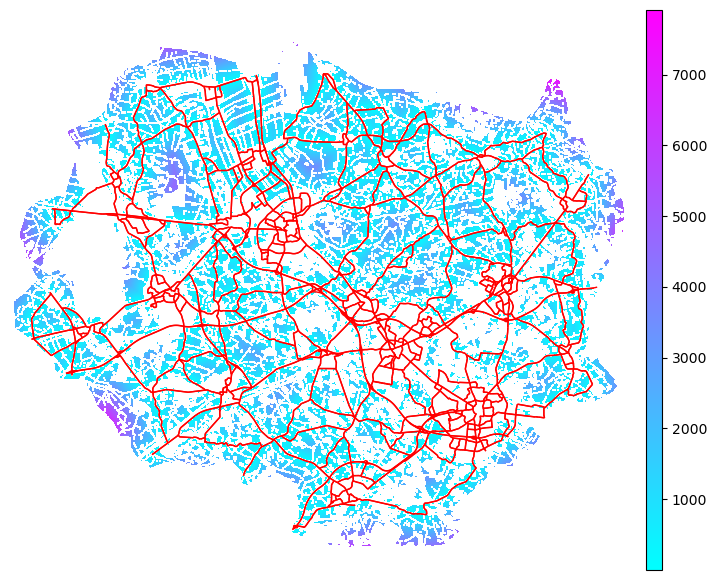

In [25]:
with rasterio.open(r'./raster/d_to_road_complete_ckdtree_50.tif') as src_road:

    d_to_road_raster = src_road.read(1)
    
    # Plot the raster
    fig, ax = plt.subplots(figsize=(8, 8))
    show(src_road, ax=ax, cmap='cool')

    # Plot the farms
    road.plot(ax=ax, color='red', linewidth=1)

    # Add colorbar
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = plt.colorbar(ax.get_images()[0], cax=cax)

    ax.axis('off')
    
    plt.savefig('/Users/wenyuc/Desktop/UT/outputs/d_to_road_complete_ckdtree_50.png', dpi=1200)

    # Show the plot
    plt.show()

### Euclidean Distance - Raster to Raster (other land use)


Read more about distance_transform_edt here. Not exactly sure if this is a spatially and mathematically valid method:
https://medium.com/@kareimtarek1972/euclidean-distance-transform-edt-introduction-5d7d7c144aa

In [56]:
def distance_to_other_lu(other_lu, og_raster):
    # Assuming that 0 represents non-industrial and 1 represents industrial in the industrial_raster
    # Invert the industrial raster so that industrial cells are represented by 0
    inverted_lu_raster = np.max(np.unique(other_lu))- other_lu

    # Calculate the Euclidean distance transform for the inverted industrial raster
    distance_transform = distance_transform_edt(inverted_lu_raster)
    
    og_raster_copy = og_raster.copy() 
    og_raster_copy[og_raster_copy==np.max(np.unique(og_raster_copy))] = 1 

    # Multiply the agricultural raster by the distance transform
    distance_to_closest_other_lu = og_raster_copy * distance_transform

    return distance_to_closest_other_lu

In [59]:
proximity_to_naure = distance_to_other_lu(nature, LU)

In [60]:
proximity_to_industry = distance_to_other_lu(industry, LU)

In [62]:
save_raster(raster_path, './raster/proximity_nature_3846.tif', proximity_to_naure)

In [61]:
save_raster(raster_path, './raster/proximity_industry_3846.tif', proximity_to_industry)

In [ ]:
# Plotting Agricultural Land Use Raster
plt.figure(figsize=(10, 10))
plt.imshow(proximity_to_naure, cmap='plasma', interpolation='none')
plt.title('Distance to Closest Industrial Cell')
plt.colorbar()
plt.tight_layout()
plt.show()

## 2. Fuzzy Membership

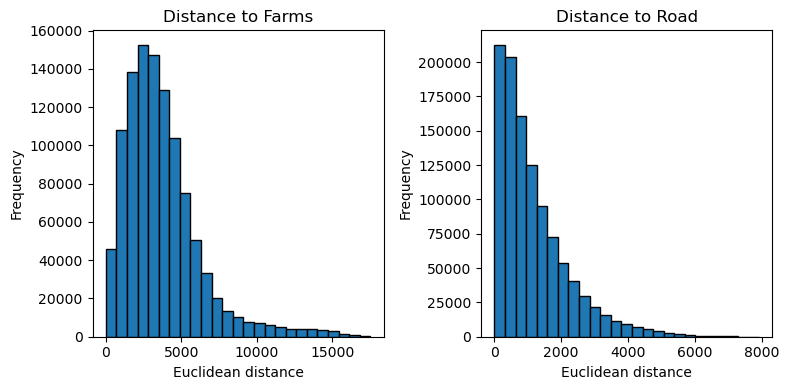

In [26]:
# Create subplots
plt.figure(figsize=(8, 4))

# Plot the first histogram
plt.subplot(1, 2, 1)
plt.hist(d_to_farm_raster[np.isfinite(d_to_farm_raster)], bins=25, edgecolor='black')
plt.title('Distance to Farms')
plt.xlabel('Euclidean distance')
plt.ylabel('Frequency')

# Plot the second histogram
plt.subplot(1, 2, 2)
plt.hist(d_to_road_raster[np.isfinite(d_to_road_raster)], bins=25, edgecolor='black')
plt.title('Distance to Road')
plt.xlabel('Euclidean distance')
plt.ylabel('Frequency')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [27]:
d_to_farm_range = d_to_farm_raster[np.isfinite(d_to_farm_raster)] 
d_to_road_range = d_to_road_raster[np.isfinite(d_to_road_raster)]

In [28]:
len(d_to_farm_range), len(d_to_road_range)

(1076595, 1076595)

In [29]:
fuzzy_farm = np.maximum(0, 1 - (d_to_farm_range - d_to_farm_range.min()) / (d_to_farm_range.max() - d_to_farm_range.min()))

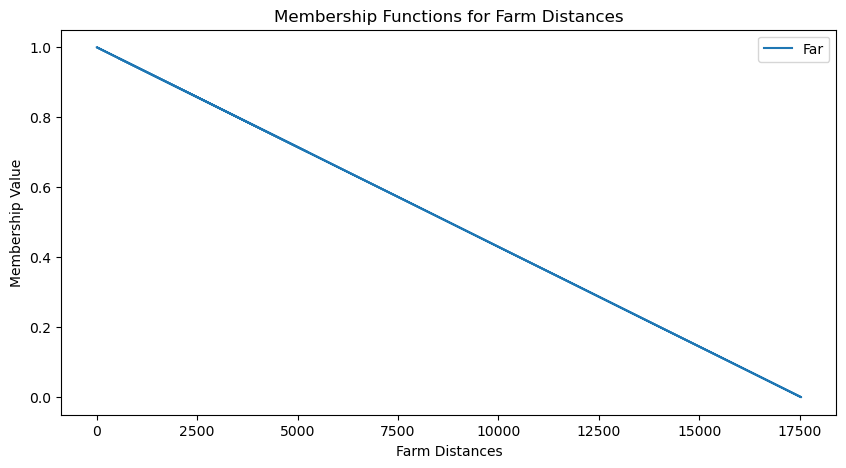

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(d_to_farm_range, fuzzy_farm, label='Far')
plt.title('Membership Functions for Farm Distances')
plt.xlabel('Farm Distances')
plt.ylabel('Membership Value')
plt.legend()
plt.show()

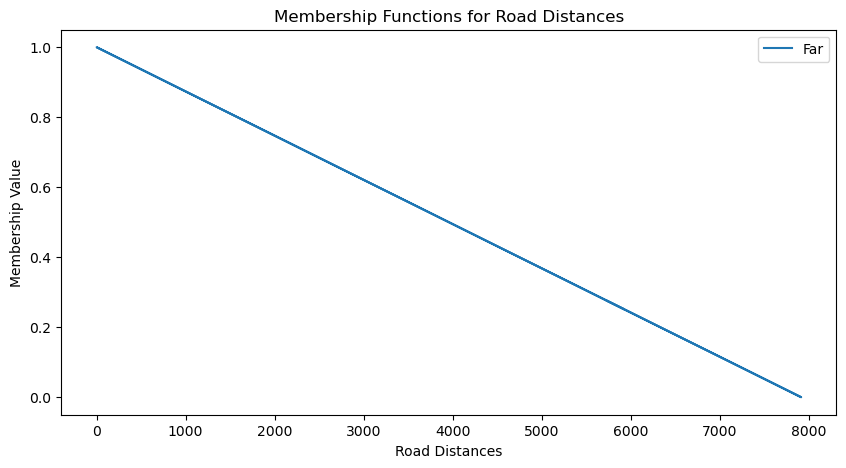

In [31]:
fuzzy_road = np.maximum(0, 1 - (d_to_road_range - d_to_road_range.min()) / (d_to_road_range.max() - d_to_road_range.min()))
plt.figure(figsize=(10, 5))
plt.plot(d_to_road_range, fuzzy_road, label='Far')
plt.title('Membership Functions for Road Distances')
plt.xlabel('Road Distances')
plt.ylabel('Membership Value')
plt.legend()
plt.show()

## 3. Fuzzy Overlay

In [ ]:
def fuzzy_analysis(*args, og_raster, og_raster_path, new_raster_path):
    """
    This is the fuzzy analysis function to perform on raster layer. 
    args: arrays of fuzzified criteria 
    """
    # Fuzzy operation AND
    fuzzy = np.minimum(args)
    # Find the indices of non-inf values in original raster layer
    non_inf_indices = np.where(np.isfinite(og_raster))
    
    if len(fuzzy) == len(non_inf_indices[0]):
        # Replace the non-inf values in original raster layer with fuzzy values
        m = np.copy(og_raster)
        m[non_inf_indices] = fuzzy
    else:
        print("Can not proceed")
    
    # Save the fuzzy array 
    with rasterio.open(og_raster_path) as src:
        profile = src.profile
        profile.update(dtype=rasterio.float32, count=1)
        with rasterio.open(new_raster_path, 'w', **profile) as dst:
            dst.write(m, 1)
    return fuzzy

In [32]:
# Fuzzy operation AND
fuzzy_and = np.minimum(fuzzy_farm, fuzzy_road)

The fuzzy operations are done for non-inf values in the LU raster layer. Therefore, now after the operation we need to export fuzzy array in the shape of the original raster layer.

In [33]:
# Find indices where fuzzy_and is not inf
non_inf_indices = np.where(np.isfinite(d_to_farm_raster))
non_inf_indices

(array([  16,   16,   17, ..., 1387, 1387, 1387]),
 array([769, 770, 768, ..., 924, 925, 926]))

In [34]:
# Check if the number of values in fuzzy array and non-inf values in original raster layer are the same
assert len(fuzzy_and) == len(non_inf_indices[0])

In [35]:
# Get a copy of the original raster array 
m = np.copy(d_to_farm_raster)

In [36]:
# Replace values in result_array with corresponding values from lu array
m[non_inf_indices] = fuzzy_and

In [37]:
# Open the original raster file
with rasterio.open(raster_path) as src:
    # Retrieve the metadata from the original raster file
    profile = src.profile
    # Update the metadata for the new raster file with the data from distances_farm
    profile.update(
        dtype=rasterio.float32,
        count=1
    )

    # Save the distances_farm array as a new raster file
    with rasterio.open(r'./raster/fuzzy_and_complete_50.tif', 'w', **profile) as dst:
        dst.write(m, 1)

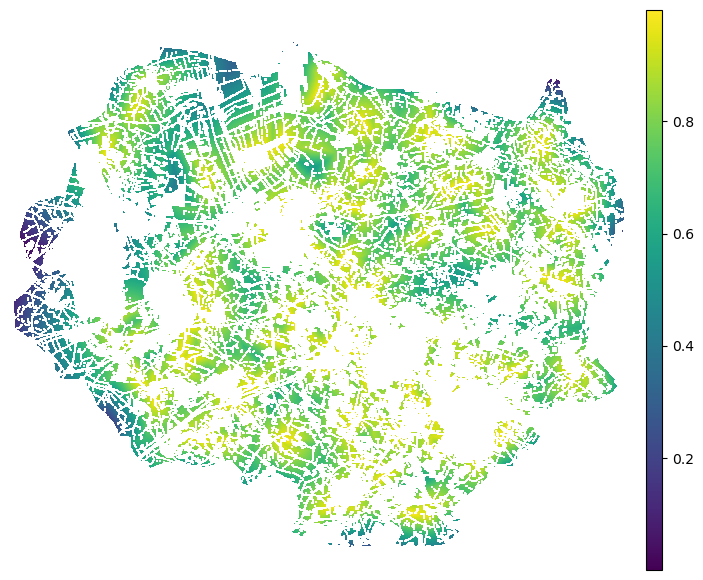

In [38]:
with rasterio.open(r'./raster/fuzzy_and_complete_50.tif') as src:

    fuzzy = src.read(1)
 
    fig, ax = plt.subplots(figsize=(8, 8))
    show(src, ax=ax)

    # farm.plot(ax=ax, color='red', markersize=10)
    # road.plot(ax=ax, color='grey', linewidth=1, alpha=0.7)

    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = plt.colorbar(ax.get_images()[0], cax=cax)
    ax.axis('off')
    plt.savefig('/Users/wenyuc/Desktop/UT/outputs/fuzzy_and_complete_1_50.png', dpi=1200)
    plt.show()

In [39]:
fuzzy[np.isinf(fuzzy)] = 0

In [4]:
# Open the original raster file
with rasterio.open(r'./raster/agri_twente.tif') as src:
    # Retrieve the metadata from the original raster file
    profile = src.profile
    # Update the metadata for the new raster file with the data from distances_farm
    profile.update(
        dtype=rasterio.float32,
        count=1
    )

    # Save the distances_farm array as a new raster file
    with rasterio.open(r'./raster/fuzzy_and_complete_1_new.tif', 'w', **profile) as dst:
        dst.write(fuzzy, 1)

## 4. Processing Suitable Areas
Now we have a raster layer that indicates how suitable a cell for building digester. We have to somehow process this data into set Plant as the CFLP model input. Set Plant should be node osmid.
* Filter by area requirement 
* Append to nodes

In [2]:
n = gpd.read_file(r"./osm_network/G_n.shp")
n.head()

,osmid,y,x,lon,lat,highway,geometry
0,0,6.863327e+06,732329.118328,6.578624,52.348177,NaN,POINT (732329.118 6863326.894)
1,1,6.862993e+06,732029.301544,6.575931,52.346343,NaN,POINT (732029.302 6862992.539)
2,2,6.863769e+06,732826.404757,NaN,NaN,NaN,POINT (732826.405 6863768.536)
3,3,6.863381e+06,733531.413357,6.589425,52.348473,NaN,POINT (733531.413 6863380.689)
4,4,6.865492e+06,731879.617087,NaN,NaN,NaN,POINT (731879.617 6865492.254)


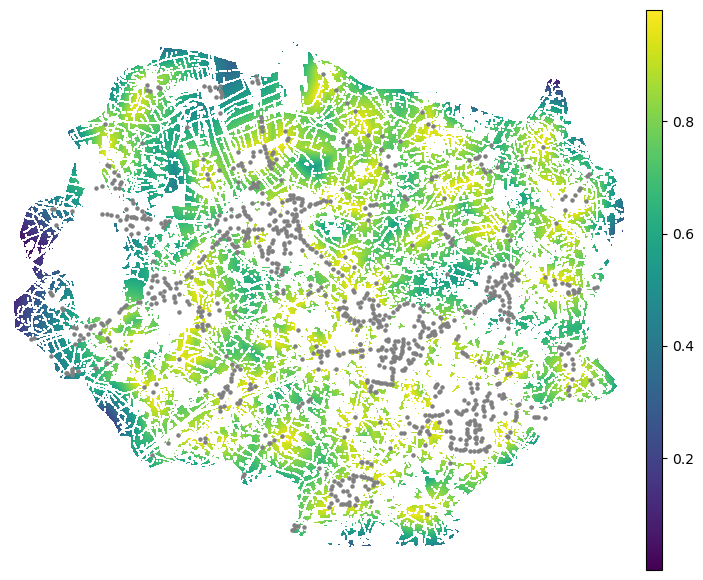

In [3]:
with rasterio.open(r'./raster/fuzzy_and_complete_50.tif') as src:

    fuzzy = src.read(1)
    transform = src.transform
    meta_info = src.meta
 
    fig, ax = plt.subplots(figsize=(8, 8))
    show(src, ax=ax)

    # road.plot(ax=ax, color='grey', alpha=0.6)
    # farm.plot(ax=ax, color='red')
    n.plot(ax=ax, color='grey', markersize=5)

    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = plt.colorbar(ax.get_images()[0], cax=cax)

    ax.axis('off')
    plt.show()

In [4]:
meta_info

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': 0.0,
 'width': 1681,
 'height': 1400,
 'count': 1,
 'crs': CRS.from_epsg(3857),
 'transform': Affine(50.0, 0.0, 703909.1518017336,
        0.0, -50.0, 6890914.957877071)}

In [5]:
# Define area requirement for each scale of digester
s_area_min = 6000
s_area_max = 10000 #m2, which = 1ha

In [6]:
# Define a cut off suitability value to filter areas
cut_off = 0.9

In [7]:
# Create a binary mask based on the cut_off values
mask = ((fuzzy >= cut_off) & np.isfinite(fuzzy))

In [8]:
# Connect the raster cells in mask based on adjacency 
label_map, num_labels = ndimage.label(mask) # num_labels - the total number of labels or connected components found in the binary mask.
    # adjacent elements along any dimension are considered connected
    # ndimage.label is a powerful tool for segmenting and identifying distinct regions in binary images, 
    # making it useful in various image processing and computer vision applications.

In [9]:
print(f'There are {num_labels} distinct connected regions in the mask.')

There are 466 distinct connected regions in the mask.


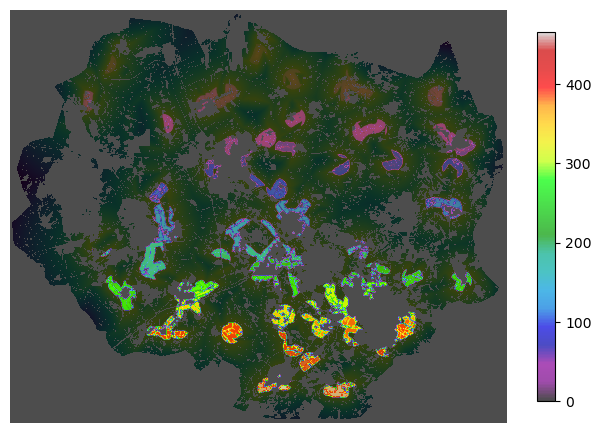

In [46]:
# Plot all areas of interest 
plt.figure(figsize=(8, 8))

# Visualize the original raster
plt.imshow(fuzzy, interpolation='none')

# Visualize the labeled components
plt.imshow(label_map, cmap='nipy_spectral', alpha=0.7)

plt.colorbar(shrink=0.6)
plt.axis('off')
plt.show()

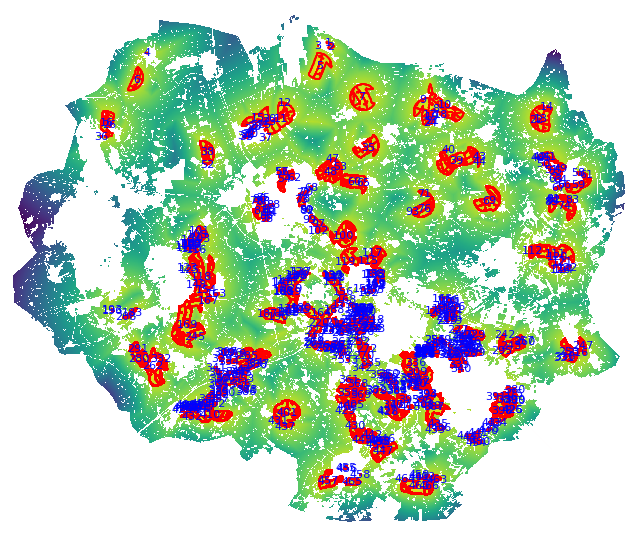

In [49]:
# Set the figure size
plt.figure(figsize=(8, 8))

# Visualize the original raster
plt.imshow(fuzzy, interpolation='none', cmap='viridis')

# Visualize the labeled components with contours
contours = plt.contour(label_map, levels=np.arange(0.5, num_labels + 0.5, 1), colors='red', linewidths=1)

# Add labels for each connected component at the centroid
for label in range(1, num_labels + 1):
    indices = np.argwhere(label_map == label)
    centroid = np.mean(indices, axis=0)
    plt.text(centroid[1], centroid[0], str(label), color='blue', fontsize=8, ha='center', va='center')

# # Customize the colorbar
# colorbar = plt.colorbar(shrink=0.8)

# Remove the axis ticks
plt.axis('off')

plt.show()

In [13]:
# Create a value array with each element as the area of each cell
cell_resolution = 50 # meter
area_array = np.ones_like(LU) * (cell_resolution * cell_resolution)

In [14]:
# Calculate the total area within each labeled region
area_sizes = ndimage.sum(area_array, label_map, range(1, num_labels + 1))

# Identify areas meeting the size criteria
valid_areas = np.where((area_sizes >= s_area_min) & (area_sizes <= s_area_max))[0]

# Create a mask for the valid areas
valid_areas_mask = np.isin(label_map, valid_areas)
np.any(valid_areas_mask) # sometime there could be that none of the component meets the criteria

True

Text(0, 0.5, 'Frequency')

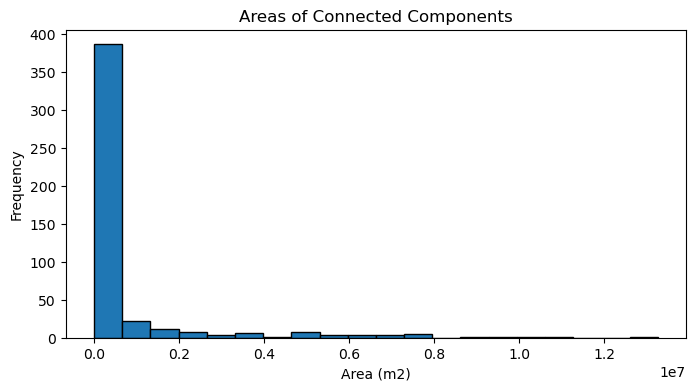

In [15]:
plt.figure(figsize=(8, 4))

# Plot the first histogram
plt.hist(area_sizes, bins=20, edgecolor='black')
plt.title('Areas of Connected Components')
plt.xlabel('Area (m2)')
plt.ylabel('Frequency')

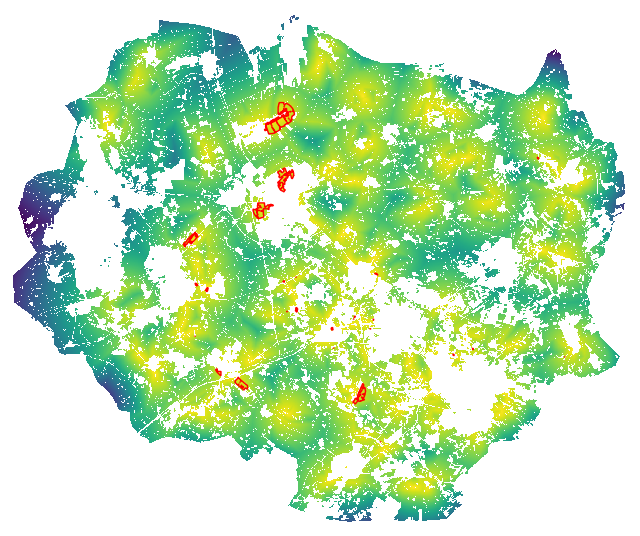

In [128]:
# Plot all areas of interest that fit the area requirement 

# Set the figure size
plt.figure(figsize=(8, 8))

# Visualize the original raster
plt.imshow(fuzzy, interpolation='none', cmap='viridis', zorder=1)

# Visualize the labeled components with contours
contours = plt.contour(valid_areas_mask, levels=np.arange(0.5, num_labels + 0.5, 1), colors='red', linewidths=1)

# # Customize the colorbar
# colorbar = plt.colorbar(shrink=0.8)

# Remove the axis ticks
plt.axis('off')

plt.show()

## 5. Prepare identified suitable areas as CFLP model inputs (set Plant)
Outputs:
* set Plant
* GeoDataFrame of polygons of suitable areas for OD matrix calculation

In [16]:
label_component, num_labels_component = ndimage.label(valid_areas_mask)

In [23]:
# Calculate the total area within each filtered components that are of interest
area_sizes_filtered = ndimage.sum(area_array, label_component, range(1, num_labels_component + 1))

In [37]:
np.unique(label_component)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26], dtype=int32)

In [38]:
unique_values, counts = np.unique(label_component, return_counts=True)

In [39]:
unique_values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26], dtype=int32)

In [26]:
polygons = []
# Iterate through each label and convert it to a polygon
for label in range(1, num_labels_component + 1):
    mask = label_component == label
    shape_info = next(shapes(mask.astype(np.uint8), mask=mask, transform=transform))
    # Extract each set of coordinates and create a Shapely Polygon
    coordinates_list = shape_info[0]['coordinates']
    polygons.append((label, MultiPolygon([Polygon(coords) for coords in coordinates_list])))

In [27]:
# Create a GeoDataFrame from the list of polygons
polygon_gdf = gpd.GeoDataFrame(polygons, columns=['Label', 'Coordinates'], geometry='Coordinates', crs=n.crs)

In [29]:
polygon_gdf['area'] = area_sizes_filtered

In [30]:
polygon_gdf

,Label,Coordinates,area
0,1,"MULTIPOLYGON (((740409.152 6878314.958, 740409...",7332500.0
1,2,"MULTIPOLYGON (((775409.152 6870914.958, 775409...",20000.0
2,3,"MULTIPOLYGON (((741009.152 6869414.958, 741009...",2545000.0
3,4,"MULTIPOLYGON (((737509.152 6864714.958, 737509...",2445000.0
4,5,"MULTIPOLYGON (((728959.152 6860714.958, 728959...",1150000.0
5,6,"MULTIPOLYGON (((753359.152 6855164.958, 753359...",32500.0
6,7,"MULTIPOLYGON (((742659.152 6854664.958, 742659...",2500.0
7,8,"MULTIPOLYGON (((741009.152 6854164.958, 741009...",25000.0
8,9,"MULTIPOLYGON (((729009.152 6853814.958, 729009...",65000.0
9,10,"MULTIPOLYGON (((730609.152 6853214.958, 730609...",107500.0


<Axes: >

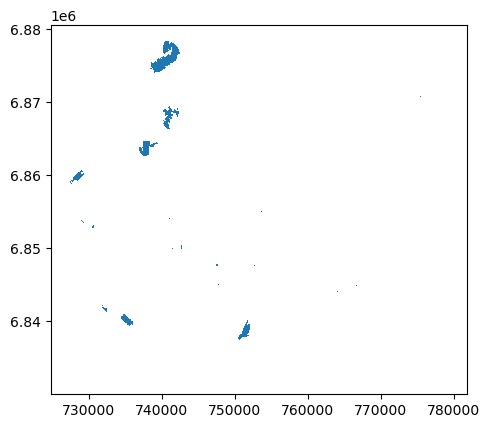

In [127]:
polygon_gdf.plot()

Maybe it is not necessary to get polygons of suitable areas. A centroid will suffice for finding nearest node. But perhaps polygon is nice for visualization. 

In [129]:
# Export GeoDataFrame
polygon_gdf.to_file(r'./raster/suitable_polygons_complete_gdf_50.shp')

/var/folders/w_/w1t73xzx35j4jtrj94fjskj80000gn/T/ipykernel_10179/1694108677.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  polygon_gdf.to_file(r'./raster/suitable_polygons_complete_gdf_50.shp')


In [130]:
# Export set Plant
folder_path = 'app_data'
store_data_to_pickle(polygon_gdf['Label'].tolist(), folder_path, 'PLANT_50.pickle') # set P